# Paris Location Data Survey - IBM DS Pro Certificate Final Assignment

## Importing the needed libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns; sns.set(color_codes=True)

print('Libraries imported.')

Libraries imported.


## Read CSV file containing the basic data about Paris and its boroughs and cleaning the resulting DataFrame

In [2]:
filename = "190617_parisBasicData.csv"

In [3]:
df = pd.read_csv(filename)

In [4]:
df.head()

,postCode,Borough,Neighborhood,avgHousePrice,croudRating
0,75001,Paris 1er Arrondissement,Paris 1er Arrondissement,12436,"6,85"
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,"6,31"
2,75003,Paris 3e Arrondissement,Paris 3e Arrondissement,12140,"8,45"
3,75004,Paris 4e Arrondissement,Paris 4e Arrondissement,12906,"6,82"
4,75005,Paris 5e Arrondissement,Paris 5e Arrondissement,11965,"8,13"


In [5]:
for idx in range(len(df["croudRating"])):
    df["croudRating"][idx] = df["croudRating"][idx].replace(",",".")

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df['croudRating'] = pd.to_numeric(df['croudRating'],errors='coerce')

In [7]:
df.dtypes

postCode           int64
Borough           object
Neighborhood      object
avgHousePrice      int64
croudRating      float64
dtype: object

In [8]:
df.head()

,postCode,Borough,Neighborhood,avgHousePrice,croudRating
0,75001,Paris 1er Arrondissement,Paris 1er Arrondissement,12436,6.85
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31
2,75003,Paris 3e Arrondissement,Paris 3e Arrondissement,12140,8.45
3,75004,Paris 4e Arrondissement,Paris 4e Arrondissement,12906,6.82
4,75005,Paris 5e Arrondissement,Paris 5e Arrondissement,11965,8.13


## Get geo coordinates of Paris

In [9]:
address = 'Paris, France'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Paris are 48.8566101, 2.3514992.


## Get all the geo coordinates of the boroughs and add them to the main DataFrame

In [40]:
latitudes = []
longitudes = []
for idx in range(75001, 75021):
    address = str(idx) + ', France'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latitudes.append(latitude)
    longitudes.append(longitude)
print(latitudes)
print(longitudes)

[48.8635124314891, 48.8653001, 48.8626656180507, 48.860845, 48.845812177079, 48.85353725, 48.855896700173, 48.8760477, 48.8806582, 48.8792014, 48.85563005, 48.83973365, 48.8293572570909, 48.8285901, 48.8428844, 48.854928, 48.8789705, 48.8965111, 48.8768285, 48.85712625]
[2.33896210560766, 2.35136, 2.36025909037783, 2.3529288, 2.34865137376913, 2.34337024122443, 2.31369940048724, 2.3156587, 2.34237184510633, 2.3543906, 2.37080568516558, 2.38005401382706, 2.36245582729451, 2.3075414, 2.2773907, 2.25531177668509, 2.2941557, 2.33431052124142, 2.3941052, 2.40925735617134]


In [41]:
df["Latitude"] = latitudes
df["Longitude"] = longitudes
df.head()

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,Latitude,Longitude
0,75001,Paris 1er Arrondissement,Paris 1er Arrondissement,12436,6.85,48.863512,2.338962
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31,48.865300,2.351360
2,75003,Paris 3e Arrondissement,Paris 3e Arrondissement,12140,8.45,48.862666,2.360259
3,75004,Paris 4e Arrondissement,Paris 4e Arrondissement,12906,6.82,48.860845,2.352929
4,75005,Paris 5e Arrondissement,Paris 5e Arrondissement,11965,8.13,48.845812,2.348651


# Data Analysis

## Basic visualizations and correlation analysis of the data

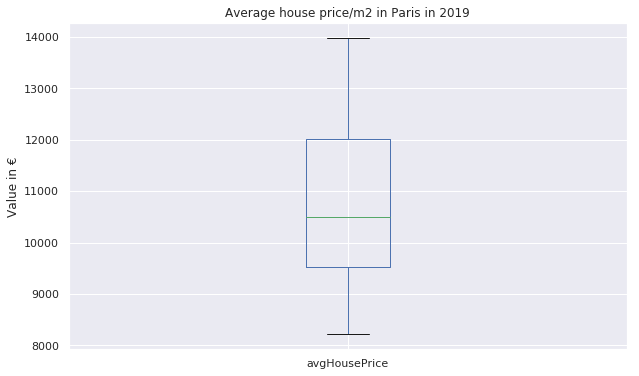

In [42]:
### type your answer here
df["avgHousePrice"].plot(kind='box', figsize=(10, 6))
plt.title('Average house price/m2 in Paris in 2019')
plt.ylabel('Value in €')
plt.show()

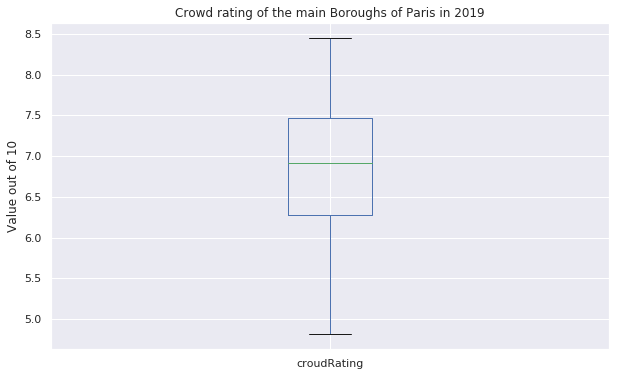

In [10]:
### type your answer here
df["croudRating"].plot(kind='box', figsize=(10, 6))
plt.title('Crowd rating of the main Boroughs of Paris in 2019')
plt.ylabel('Value out of 10')
plt.show()

## Plotting the key data into Folium Maps

In [11]:
paris_geo = r'arrondissements_postPro.geojson' # geojson file

In [12]:
# create a plain paris map
paris_map1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
paris_map1.choropleth(
    geo_data=paris_geo,
    data=df,
    columns=['Borough', 'avgHousePrice'],
    key_on='feature.properties.l_ar',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average House Price'
)

# display map
paris_map1

In [13]:
paris_map2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
paris_map2.choropleth(
    geo_data=paris_geo,
    data=df,
    columns=['Borough', 'croudRating'],
    key_on='feature.properties.l_ar',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crowd Rating'
)

# display map
paris_map2

In [14]:
tmpDf = df[['avgHousePrice', 'croudRating']] # passing in years 1980 - 2013 to exclude the 'total' column
correlation = tmpDf['avgHousePrice'].corr(tmpDf['croudRating'])
correlation

0.49730308893032704

Text(0, 0.5, 'Crowd rating')

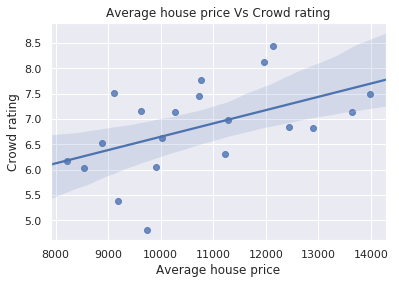

In [17]:
ax = sns.regplot(x="avgHousePrice", y="croudRating", data=tmpDf)
plt.title('Average house price Vs Crowd rating')
plt.xlabel('Average house price')
plt.ylabel('Crowd rating')

## Binning the average house prices and building a new custom score of quality/price ratio

In [18]:
bins = np.linspace(min(df["avgHousePrice"]), max(df["avgHousePrice"]), 10)
group_names = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#df['horsepower-binned'] = pd.cut(df['horsepower'], bins, labels=group_names, include_lowest=True )
df['avgHousePrice_binned'] = pd.cut(df['avgHousePrice'], bins, labels=group_names, include_lowest=True )
df['avgHousePrice_binned'] = pd.to_numeric(df['avgHousePrice_binned'],errors='coerce')
df['avgHousePrice_binned'] = 10 - df['avgHousePrice_binned']
df.head()
df['boroughCustomScore'] = df['croudRating'] * df['avgHousePrice_binned'] / 100. * 10
df.head()
np.max(df['avgHousePrice'])
df.head()

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,avgHousePrice_binned,boroughCustomScore
0,75001,Paris 1er Arrondissement,Paris 1er Arrondissement,12436,6.85,3,2.055
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31,5,3.155
2,75003,Paris 3e Arrondissement,Paris 3e Arrondissement,12140,8.45,3,2.535
3,75004,Paris 4e Arrondissement,Paris 4e Arrondissement,12906,6.82,2,1.364
4,75005,Paris 5e Arrondissement,Paris 5e Arrondissement,11965,8.13,4,3.252


## Ranking the boroughs based on the obtained score and visualize the results in a Map

In [19]:
df.dtypes
df.sort_values(by=['boroughCustomScore'], inplace=False, ascending=False)

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,avgHousePrice_binned,boroughCustomScore
11,75012,Paris 12e Arrondissement,Paris 12e Arrondissement,9109,7.52,8,6.016
18,75019,Paris 19e Arrondissement,Paris 19e Arrondissement,8214,6.17,9,5.553
19,75020,Paris 20e Arrondissement,Paris 20e Arrondissement,8537,6.03,9,5.427
12,75013,Paris 13e Arrondissement,Paris 13e Arrondissement,8874,6.52,8,5.216
14,75015,Paris 15e Arrondissement,Paris 15e Arrondissement,9627,7.16,7,5.012
8,75009,Paris 9e Arrondissement,Paris 9e Arrondissement,10759,7.77,6,4.662
10,75011,Paris 11e Arrondissement,Paris 11e Arrondissement,10021,6.63,7,4.641
15,75016,Paris 16e Arrondissement,Paris 16e Arrondissement,10719,7.46,6,4.476
17,75018,Paris 18e Arrondissement,Paris 18e Arrondissement,9188,5.38,8,4.304
16,75017,Paris 17e Arrondissement,Paris 17e Arrondissement,10262,7.14,6,4.284


In [130]:
paris_map3 = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
paris_map3.choropleth(
    geo_data=paris_geo,
    data=df,
    columns=['Borough', 'boroughCustomScore'],
    key_on='feature.properties.l_ar',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Borough Mixed Score'
)

# display map
paris_map3

# Modeling stage

## General clustering of the Foursquare Data for Paris

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
paris_data = df

In [54]:
CLIENT_ID = 'RN43WUSXYRMNG0RZW2FMAK2SWXHMLVBH1NNUVMNONYB20PF3' # your Foursquare ID
CLIENT_SECRET = 'ICXWCZPIYRQZV3LZCT2PK2M0PA501HCKHCERVHCBCW5ZYC2M' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RN43WUSXYRMNG0RZW2FMAK2SWXHMLVBH1NNUVMNONYB20PF3
CLIENT_SECRET:ICXWCZPIYRQZV3LZCT2PK2M0PA501HCKHCERVHCBCW5ZYC2M


In [55]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Paris 1er Arrondissement are 48.8635124314891, 2.33896210560766.


In [56]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RN43WUSXYRMNG0RZW2FMAK2SWXHMLVBH1NNUVMNONYB20PF3&client_secret=ICXWCZPIYRQZV3LZCT2PK2M0PA501HCKHCERVHCBCW5ZYC2M&v=20180605&ll=48.8635124314891,2.33896210560766&radius=500&limit=100'

In [57]:
results = requests.get(url).json()
results
type(results)

dict

In [58]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [59]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Jardin du Palais Royal,Garden,48.864941,2.337728
1,Comédie-Française,Theater,48.863088,2.336612
2,Palais Royal,Historic Site,48.863758,2.337121
3,Place du Palais Royal,Plaza,48.862523,2.336688
4,Christian Louboutin,Shoe Store,48.862697,2.340757


In [60]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [61]:
paris_venues = getNearbyVenues(names=paris_data['Neighborhood'],
                                   latitudes=paris_data['Latitude'],
                                   longitudes=paris_data['Longitude']
                                  )

Paris 1er Arrondissement
Paris 2e Arrondissement
Paris 3e Arrondissement
Paris 4e Arrondissement
Paris 5e Arrondissement
Paris 6e Arrondissement
Paris 7e Arrondissement
Paris 8e Arrondissement
Paris 9e Arrondissement
Paris 10e Arrondissement
Paris 11e Arrondissement
Paris 12e Arrondissement
Paris 13e Arrondissement
Paris 14e Arrondissement
Paris 15e Arrondissement
Paris 16e Arrondissement
Paris 17e Arrondissement
Paris 18e Arrondissement
Paris 19e Arrondissement
Paris 20e Arrondissement


In [62]:
paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris 1er Arrondissement,48.863512,2.338962,Jardin du Palais Royal,48.864941,2.337728,Garden
1,Paris 1er Arrondissement,48.863512,2.338962,Comédie-Française,48.863088,2.336612,Theater
2,Paris 1er Arrondissement,48.863512,2.338962,Palais Royal,48.863758,2.337121,Historic Site
3,Paris 1er Arrondissement,48.863512,2.338962,Place du Palais Royal,48.862523,2.336688,Plaza
4,Paris 1er Arrondissement,48.863512,2.338962,Christian Louboutin,48.862697,2.340757,Shoe Store


In [63]:
paris_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Paris 10e Arrondissement,62,62,62,62,62,62
Paris 11e Arrondissement,100,100,100,100,100,100
Paris 12e Arrondissement,22,22,22,22,22,22
Paris 13e Arrondissement,49,49,49,49,49,49
Paris 14e Arrondissement,24,24,24,24,24,24


In [64]:
paris_venues['Neighborhood'].head()

0    Paris 1er Arrondissement
1    Paris 1er Arrondissement
2    Paris 1er Arrondissement
3    Paris 1er Arrondissement
4    Paris 1er Arrondissement
Name: Neighborhood, dtype: object

In [65]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 194 uniques categories.


In [66]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")
paris_onehot.head()

,African Restaurant,Alsatian Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lebanese Restaurant,Liquor Store,Lounge,Lyonese Bouchon,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pizza Place,Platform,Plaza,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Sandwich Place,Savoyard Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Souvenir Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [67]:
# add neighborhood column back to dataframe
paris_onehot['zNeighborhood'] = paris_venues['Neighborhood']
paris_onehot.rename(index=str, columns={"zNeighborhood": "Neighborhood"}, inplace=True)
paris_onehot.head()

,African Restaurant,Alsatian Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lebanese Restaurant,Liquor Store,Lounge,Lyonese Bouchon,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pizza Place,Platform,Plaza,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Sandwich Place,Savoyard Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Souvenir Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Paris 1er Arrondissement
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Paris 1er Arrondissement
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [68]:
# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]
paris_onehot.head()

,Neighborhood,African Restaurant,Alsatian Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lebanese Restaurant,Liquor Store,Lounge,Lyonese Bouchon,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pizza Place,Platform,Plaza,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Sandwich Place,Savoyard Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Souvenir Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [69]:
paris_onehot.shape

(1286, 195)

In [70]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,African Restaurant,Alsatian Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lebanese Restaurant,Liquor Store,Lounge,Lyonese Bouchon,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pizza Place,Platform,Plaza,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Sandwich Place,Savoyard Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Souvenir Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Paris 10e Arrondissement,0.016129,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.048387,0.032258,0.0,0.000000,0.000000,0.00,0.0,0.032258,0.000000,0.000000,0.0,0.0,0.00,0.00,0.016129,0.00,0.00,0.000000,0.016129,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.048387,0.0,0.0,0.000000,0.0,0.016129,0.0,0.0,0.0,0.00,0.016129,0.016129,0.016129,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.016129,0.000000,0.0,0.0,0.000000,0.0,0.016129,0.0,0.0,0.0,0.177419,0.0,0.000000,0.0,0.000000,0.016129,0.0,0.0,0.0,0.016129,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.016129,0.000000,0.00,0.0,0.0,0.0,0.032258,0.112903,0.0,0.00,0.048387,0.0,0.000000,0.048387,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.016129,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.016129,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.016129,0.000000,0.0,0.00,0.00,0.0,0.0,0.016129,0.048387,0.000000,0.0,0.0,0.016129,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.016129,0.0,0.0,0.0,0.000000,0.00,0.0,0.016129,0.00,0.016129,0.0
1,Paris 11e Arrondissement,0.000000,0.

In [71]:
paris_grouped.shape

(20, 195)

In [72]:
num_top_venues = 5
maxIndex = 10
idx = 0

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    idx+=1
    if(idx >= maxIndex):
            break

----Paris 10e Arrondissement----
                 venue  freq
0    French Restaurant  0.18
1                Hotel  0.11
2           Restaurant  0.05
3  Japanese Restaurant  0.05
4    Indian Restaurant  0.05


----Paris 11e Arrondissement----
                venue  freq
0   French Restaurant  0.14
1  Italian Restaurant  0.05
2                 Bar  0.05
3         Pizza Place  0.05
4               Hotel  0.04


----Paris 12e Arrondissement----
               venue  freq
0  French Restaurant  0.18
1              Hotel  0.14
2               Road  0.05
3                Bar  0.05
4  Convenience Store  0.05


----Paris 13e Arrondissement----
                   venue  freq
0  Vietnamese Restaurant  0.24
1       Asian Restaurant  0.14
2        Thai Restaurant  0.08
3     Chinese Restaurant  0.08
4      French Restaurant  0.06


----Paris 14e Arrondissement----
              venue  freq
0            Bakery  0.17
1             Hotel  0.08
2            Hostel  0.04
3  Sushi Restaurant  0.04
4      

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [74]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Paris 10e Arrondissement,French Restaurant,Hotel,Bakery,Restaurant,Coffee Shop
1,Paris 11e Arrondissement,French Restaurant,Italian Restaurant,Bar,Pizza Place,Coffee Shop
2,Paris 12e Arrondissement,French Restaurant,Hotel,Road,Museum,Music Venue
3,Paris 13e Arrondissement,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Thai Restaurant,French Restaurant
4,Paris 14e Arrondissement,Bakery,Hotel,Bistro,Sushi Restaurant,Farmers Market


## Evaluating the best K for Kmeans clustering algorithm

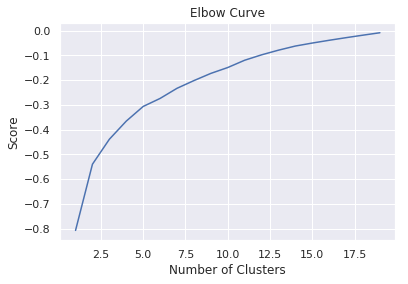

In [75]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)
score = [kmeans[i].fit(paris_grouped_clustering).score(paris_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## K=7 is chosen

In [76]:
# set number of clusters
kclusters = 7

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 4, 2, 3, 6, 1, 4, 6, 6], dtype=int32)

In [77]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,75001,Paris 1er Arrondissement,Paris 1er Arrondissement,12436,6.85,48.863512,2.338962,3,2.055,0,French Restaurant,Hotel,Café,Plaza,Historic Site
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31,48.865300,2.351360,5,3.155,6,French Restaurant,Cocktail Bar,Chinese Restaurant,Wine Bar,Bakery
2,75003,Paris 3e Arrondissement,Paris 3e Arrondissement,12140,8.45,48.862666,2.360259,3,2.535,6,Italian Restaurant,French Restaurant,Bistro,Hotel,Chinese Restaurant
3,75004,Paris 4e Arrondissement,Paris 4e Arrondissement,12906,6.82,48.860845,2.352929,2,1.364,6,French Restaurant,Bakery,Burger Joint,Coffee Shop,Art Gallery
4,75005,Paris 5e Arrondissement,Paris 5e Arrondissement,11965,8.13,48.845812,2.348651,4,3.252,0,French Restaurant,Bar,Hotel,Bakery,Italian Restaurant


## Post processing the clustering Data for a better interpretation of the clusters using bar plots

In [78]:
parisVenuesIndexes = paris_grouped.columns[1:]

In [79]:
histPd = pd.DataFrame(columns=parisVenuesIndexes)
for idx2 in range(7):
    y={}
    for idx1 in parisVenuesIndexes:           
        curentCount = paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["1st Most Common Venue"] == idx1)].count()[0]+\
                        paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["2nd Most Common Venue"] == idx1)].count()[0]+\
                        paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["3rd Most Common Venue"] == idx1)].count()[0]
        y.update( {idx1 : curentCount} )
    histPd = histPd.append(y, ignore_index=True)
histPd.head()

,African Restaurant,Alsatian Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lebanese Restaurant,Liquor Store,Lounge,Lyonese Bouchon,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pizza Place,Platform,Plaza,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Sandwich Place,Savoyard Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Souvenir Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [80]:
total = histPd.T.sum(axis=1)
histPd=histPd.T
histPd["Total"] = total
tmpPd2 = histPd.sort_values(by=['Total'], inplace=False, ascending=False).reset_index()
tmpPd2["index"][:20]

0            French Restaurant
1                        Hotel
2                       Bakery
3           Italian Restaurant
4                         Café
5     Bike Rental / Bike Share
6                          Bar
7                       Bistro
8           Chinese Restaurant
9                  Music Venue
10                      Circus
11                Cocktail Bar
12                        Road
13                    Bus Stop
14                Burger Joint
15                   Bookstore
16                 Supermarket
17                  Racecourse
18            Asian Restaurant
19       Vietnamese Restaurant
Name: index, dtype: object

In [81]:
topIndexes = tmpPd2["index"][:20].tolist()
topIndexes

['French Restaurant',
 'Hotel',
 'Bakery',
 'Italian Restaurant',
 'Café',
 'Bike Rental / Bike Share',
 'Bar',
 'Bistro',
 'Chinese Restaurant',
 'Music Venue',
 'Circus',
 'Cocktail Bar',
 'Road',
 'Bus Stop',
 'Burger Joint',
 'Bookstore',
 'Supermarket',
 'Racecourse',
 'Asian Restaurant',
 'Vietnamese Restaurant']

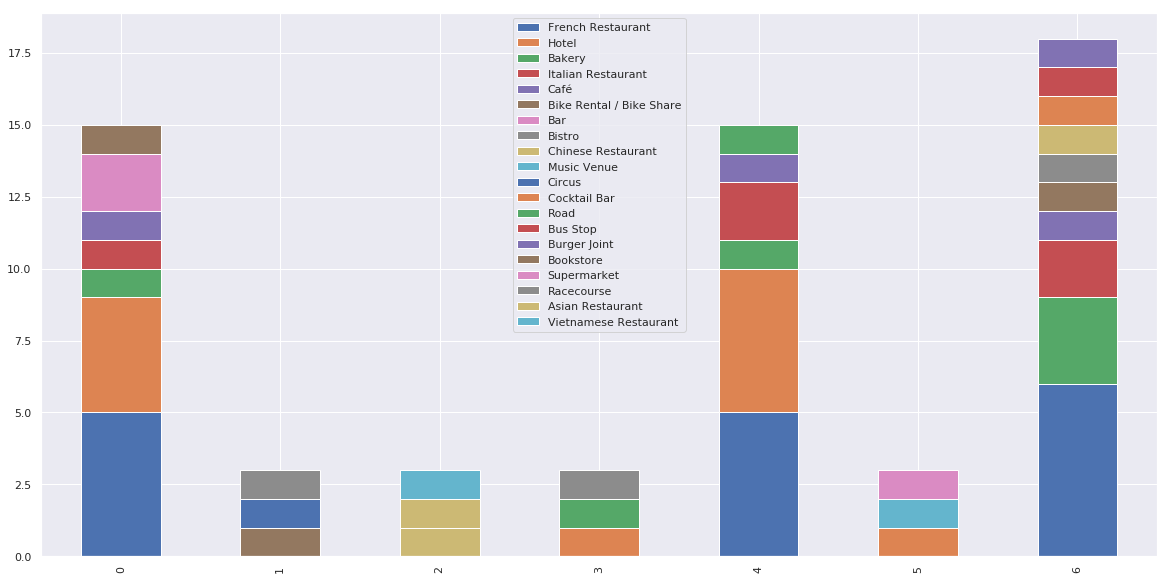

In [82]:
histPd = pd.DataFrame(columns=topIndexes)
for idx2 in range(7):
    y={}
    for idx1 in topIndexes:           
        curentCount = paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["1st Most Common Venue"] == idx1)].count()[0]+\
                        paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["2nd Most Common Venue"] == idx1)].count()[0]+\
                        paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["3rd Most Common Venue"] == idx1)].count()[0]
        y.update( {idx1 : curentCount} )
    histPd = histPd.append(y, ignore_index=True)
histPd.head()
histPd.plot(kind='bar', 
             alpha=1, # 0-1, default value a= 0.5
             stacked=True,
             figsize=(20, 10),
            )

## Plot the clustering results using Folium

In [83]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Interpreting the obtained clusters

In [84]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Paris 1er Arrondissement,48.863512,2.338962,3,2.055,0,French Restaurant,Hotel,Café,Plaza,Historic Site
4,Paris 5e Arrondissement,48.845812,2.348651,4,3.252,0,French Restaurant,Bar,Hotel,Bakery,Italian Restaurant
5,Paris 6e Arrondissement,48.853537,2.343370,1,0.750,0,French Restaurant,Bookstore,Hotel,Creperie,Seafood Restaurant
8,Paris 9e Arrondissement,48.880658,2.342372,6,4.662,0,French Restaurant,Hotel,Bakery,Cocktail Bar,Italian Restaurant
10,Paris 11e Arrondissement,48.855630,2.370806,7,4.641,0,French Restaurant,Italian Restaurant,Bar,Pizza Place,Coffee Shop


In [85]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Paris 16e Arrondissement,48.854928,2.255312,6,4.476,1,Circus,Racecourse,Bike Rental / Bike Share,Lake,Exhibit


In [86]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Paris 13e Arrondissement,48.829357,2.362456,8,5.216,2,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Thai Restaurant,French Restaurant


In [87]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Paris 14e Arrondissement,48.82859,2.307541,7,4.242,3,Bakery,Hotel,Bistro,Sushi Restaurant,Farmers Market


In [88]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Paris 7e Arrondissement,48.855897,2.313699,1,0.713,4,French Restaurant,Hotel,Café,Plaza,Italian Restaurant
7,Paris 8e Arrondissement,48.876048,2.315659,5,3.495,4,French Restaurant,Hotel,Italian Restaurant,Supermarket,Theater
9,Paris 10e Arrondissement,48.879201,2.354391,7,3.367,4,French Restaurant,Hotel,Bakery,Restaurant,Coffee Shop
11,Paris 12e Arrondissement,48.839734,2.380054,8,6.016,4,French Restaurant,Hotel,Road,Museum,Music Venue
16,Paris 17e Arrondissement,48.878971,2.294156,6,4.284,4,Hotel,French Restaurant,Italian Restaurant,Bakery,Seafood Restaurant


In [89]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
19,Paris 20e Arrondissement,48.857126,2.409257,9,5.427,5,Hotel,Supermarket,Music Venue,French Restaurant,Tram Station


In [90]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Paris 2e Arrondissement,48.865300,2.351360,5,3.155,6,French Restaurant,Cocktail Bar,Chinese Restaurant,Wine Bar,Bakery
2,Paris 3e Arrondissement,48.862666,2.360259,3,2.535,6,Italian Restaurant,French Restaurant,Bistro,Hotel,Chinese Restaurant
3,Paris 4e Arrondissement,48.860845,2.352929,2,1.364,6,French Restaurant,Bakery,Burger Joint,Coffee Shop,Art Gallery
14,Paris 15e Arrondissement,48.842884,2.277391,7,5.012,6,French Restaurant,Bakery,Italian Restaurant,Beer Garden,Hotel
17,Paris 18e Arrondissement,48.896511,2.334311,8,4.304,6,Bike Rental / Bike Share,French Restaurant,Bus Stop,Restaurant,Bakery
18,Paris 19e Arrondissement,48.876829,2.394105,9,5.553,6,French Restaurant,Café,Bakery,Bar,Bistro


# Special focus on the venues related to Wellness in Paris

## Building the adequate venues indexes

In [91]:
paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris 1er Arrondissement,48.863512,2.338962,Jardin du Palais Royal,48.864941,2.337728,Garden
1,Paris 1er Arrondissement,48.863512,2.338962,Comédie-Française,48.863088,2.336612,Theater
2,Paris 1er Arrondissement,48.863512,2.338962,Palais Royal,48.863758,2.337121,Historic Site
3,Paris 1er Arrondissement,48.863512,2.338962,Place du Palais Royal,48.862523,2.336688,Plaza
4,Paris 1er Arrondissement,48.863512,2.338962,Christian Louboutin,48.862697,2.340757,Shoe Store


In [92]:
wellnessList = ['Garden', 'Spa', 'Sculpture Garden', 'Salad Place', 'Pedestrian Plaza', 'Tea Room', 'Gym / Fitness Center', 'Vegetarian / Vegan Restaurant', 'Yoga Studio', 'Park', 'Gluten-free Restaurant', 'Health Food Store', 'Gym', 'Tennis Court', 'Gym Pool', 'Lake', 'Bike Rental / Bike Share', 'Martial Arts Dojo', 'Stadium', 'Soccer Stadium']

In [93]:
allCategoriesList = np.ndarray.tolist(paris_venues["Venue Category"].unique())

In [94]:
type(allCategoriesList)

list

In [95]:
notWellnessList = []
for idx in allCategoriesList:
    takeIt = True
    for idx2 in wellnessList:
        if(idx == idx2):
            takeIt = False
    if(takeIt == True):
        notWellnessList.append(idx)
len(notWellnessList)

174

In [96]:
wellnessList

['Garden',
 'Spa',
 'Sculpture Garden',
 'Salad Place',
 'Pedestrian Plaza',
 'Tea Room',
 'Gym / Fitness Center',
 'Vegetarian / Vegan Restaurant',
 'Yoga Studio',
 'Park',
 'Gluten-free Restaurant',
 'Health Food Store',
 'Gym',
 'Tennis Court',
 'Gym Pool',
 'Lake',
 'Bike Rental / Bike Share',
 'Martial Arts Dojo',
 'Stadium',
 'Soccer Stadium']

In [97]:
paris_venues.shape

(1286, 7)

In [98]:
paris_venues_wellness = paris_venues.copy()
for idx in range(len(notWellnessList)):
    paris_venues_wellness.drop(paris_venues_wellness.loc[paris_venues_wellness['Venue Category']==notWellnessList[idx]].index, inplace=True)
paris_venues_wellness = paris_venues_wellness.reset_index()
paris_venues_wellness = paris_venues_wellness.drop("index", axis=1)
paris_venues_wellness.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris 1er Arrondissement,48.863512,2.338962,Jardin du Palais Royal,48.864941,2.337728,Garden
1,Paris 1er Arrondissement,48.863512,2.338962,Thémaé,48.863589,2.339756,Spa
2,Paris 1er Arrondissement,48.863512,2.338962,Colonnes de Buren,48.863618,2.336917,Sculpture Garden
3,Paris 1er Arrondissement,48.863512,2.338962,Lémoni,48.864795,2.341292,Salad Place
4,Paris 1er Arrondissement,48.863512,2.338962,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza


In [99]:
np.ndarray.tolist(paris_venues_wellness["Venue Category"].unique())

['Garden',
 'Spa',
 'Sculpture Garden',
 'Salad Place',
 'Pedestrian Plaza',
 'Tea Room',
 'Gym / Fitness Center',
 'Vegetarian / Vegan Restaurant',
 'Yoga Studio',
 'Park',
 'Gluten-free Restaurant',
 'Health Food Store',
 'Gym',
 'Tennis Court',
 'Gym Pool',
 'Lake',
 'Bike Rental / Bike Share',
 'Martial Arts Dojo',
 'Stadium',
 'Soccer Stadium']

In [100]:
paris_venues_wellness.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Paris 10e Arrondissement,1,1,1,1,1,1
Paris 11e Arrondissement,7,7,7,7,7,7
Paris 12e Arrondissement,2,2,2,2,2,2
Paris 13e Arrondissement,2,2,2,2,2,2
Paris 14e Arrondissement,3,3,3,3,3,3


In [101]:
paris_venues_wellness['Neighborhood'].head()

0    Paris 1er Arrondissement
1    Paris 1er Arrondissement
2    Paris 1er Arrondissement
3    Paris 1er Arrondissement
4    Paris 1er Arrondissement
Name: Neighborhood, dtype: object

In [102]:
print('There are {} uniques categories.'.format(len(paris_venues_wellness['Venue Category'].unique())))

There are 20 uniques categories.


## Performing the clustering based on Wellness data in Paris

In [103]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues_wellness[['Venue Category']], prefix="", prefix_sep="")
paris_onehot.head()

,Bike Rental / Bike Share,Garden,Gluten-free Restaurant,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Lake,Martial Arts Dojo,Park,Pedestrian Plaza,Salad Place,Sculpture Garden,Soccer Stadium,Spa,Stadium,Tea Room,Tennis Court,Vegetarian / Vegan Restaurant,Yoga Studio
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [104]:
# add neighborhood column back to dataframe
paris_onehot['zNeighborhood'] = paris_venues_wellness['Neighborhood']
paris_onehot.rename(index=str, columns={"zNeighborhood": "Neighborhood"}, inplace=True)
paris_onehot.head()

,Bike Rental / Bike Share,Garden,Gluten-free Restaurant,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Lake,Martial Arts Dojo,Park,Pedestrian Plaza,Salad Place,Sculpture Garden,Soccer Stadium,Spa,Stadium,Tea Room,Tennis Court,Vegetarian / Vegan Restaurant,Yoga Studio,Neighborhood
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Paris 1er Arrondissement
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Paris 1er Arrondissement
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Paris 1er Arrondissement
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Paris 1er Arrondissement
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Paris 1er Arrondissement


In [105]:
# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]
paris_onehot.head()

,Neighborhood,Bike Rental / Bike Share,Garden,Gluten-free Restaurant,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Lake,Martial Arts Dojo,Park,Pedestrian Plaza,Salad Place,Sculpture Garden,Soccer Stadium,Spa,Stadium,Tea Room,Tennis Court,Vegetarian / Vegan Restaurant,Yoga Studio
0,Paris 1er Arrondissement,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [106]:
paris_onehot.shape

(72, 21)

In [107]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,Bike Rental / Bike Share,Garden,Gluten-free Restaurant,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Lake,Martial Arts Dojo,Park,Pedestrian Plaza,Salad Place,Sculpture Garden,Soccer Stadium,Spa,Stadium,Tea Room,Tennis Court,Vegetarian / Vegan Restaurant,Yoga Studio
0,Paris 10e Arrondissement,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,Paris 11e Arrondissement,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.428571,0.0
2,Paris 12e Arrondissement,0.0,0.5,0.0,0.000000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,Paris 13e Arrondissement,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.000000,0.0
4,Paris 14e Arrondissement,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


## Building a Wellness Score and a Final Score columns and adding them to the main DataFrame

In [108]:
paris_grouped_sum = paris_onehot.groupby('Neighborhood').sum().reset_index()
paris_grouped_sum["Total"] = paris_grouped_sum.sum(axis=1)
paris_grouped_sum["wellnessScore"] = paris_grouped_sum["Total"]/np.max(paris_grouped_sum["Total"])*10.
paris_grouped_sum
df["wellnessScore"] = paris_grouped_sum["wellnessScore"]
df["finalScore"] = df["wellnessScore"]*df["boroughCustomScore"]/10.
df.sort_values(by=['finalScore'], inplace=False, ascending=False).head(5)

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore
12,75013,Paris 13e Arrondissement,Paris 13e Arrondissement,8874,6.52,48.829357,2.362456,8,5.216,10.00,5.216000
13,75014,Paris 14e Arrondissement,Paris 14e Arrondissement,9912,6.06,48.828590,2.307541,7,4.242,10.00,4.242000
10,75011,Paris 11e Arrondissement,Paris 11e Arrondissement,10021,6.63,48.855630,2.370806,7,4.641,7.50,3.480750
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31,48.865300,2.351360,5,3.155,8.75,2.760625
17,75018,Paris 18e Arrondissement,Paris 18e Arrondissement,9188,5.38,48.896511,2.334311,8,4.304,6.25,2.690000


In [131]:
df.sort_values(by=['finalScore'], inplace=False, ascending=False)

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore
12,75013,Paris 13e Arrondissement,Paris 13e Arrondissement,8874,6.52,48.829357,2.362456,8,5.216,10.00,5.216000
13,75014,Paris 14e Arrondissement,Paris 14e Arrondissement,9912,6.06,48.828590,2.307541,7,4.242,10.00,4.242000
10,75011,Paris 11e Arrondissement,Paris 11e Arrondissement,10021,6.63,48.855630,2.370806,7,4.641,7.50,3.480750
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31,48.865300,2.351360,5,3.155,8.75,2.760625
17,75018,Paris 18e Arrondissement,Paris 18e Arrondissement,9188,5.38,48.896511,2.334311,8,4.304,6.25,2.690000
14,75015,Paris 15e Arrondissement,Paris 15e Arrondissement,9627,7.16,48.842884,2.277391,7,5.012,5.00,2.506000
8,75009,Paris 9e Arrondissement,Paris 9e Arrondissement,10759,7.77,48.880658,2.342372,6,4.662,5.00,2.331000
11,75012,Paris 12e Arrondissement,Paris 12e Arrondissement,9109,7.52,48.839734,2.380054,8,6.016,3.75,2.256000
19,75020,Paris 20e Arrondissement,Paris 20e Arrondissement,8537,6.03,48.857126,2.409257,9,5.427,3.75,2.035125
7,75008,Paris 8e Arrondissement,Paris 8e Arrondissement,11272,6.99,48.876048,2.315659,5,3.495,5.00,1.747500


In [109]:
paris_grouped.shape

(20, 21)

In [110]:
num_top_venues = 5
maxIndex = 10
idx = 0

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    idx+=1
    if(idx >= maxIndex):
            break

----Paris 10e Arrondissement----
                           venue  freq
0         Gluten-free Restaurant   1.0
1       Bike Rental / Bike Share   0.0
2                    Salad Place   0.0
3  Vegetarian / Vegan Restaurant   0.0
4                   Tennis Court   0.0


----Paris 11e Arrondissement----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.43
1                       Tea Room  0.29
2               Pedestrian Plaza  0.14
3           Gym / Fitness Center  0.14
4                    Salad Place  0.00


----Paris 12e Arrondissement----
                           venue  freq
0              Health Food Store   0.5
1                         Garden   0.5
2       Bike Rental / Bike Share   0.0
3                    Salad Place   0.0
4  Vegetarian / Vegan Restaurant   0.0


----Paris 13e Arrondissement----
                           venue  freq
0                   Tennis Court   0.5
1                           Park   0.5
2       Bike Rental / Bike Share   0.0
3   

In [111]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [112]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Paris 10e Arrondissement,Gluten-free Restaurant,Yoga Studio,Vegetarian / Vegan Restaurant,Garden,Gym
1,Paris 11e Arrondissement,Vegetarian / Vegan Restaurant,Tea Room,Gym / Fitness Center,Pedestrian Plaza,Yoga Studio
2,Paris 12e Arrondissement,Garden,Health Food Store,Yoga Studio,Vegetarian / Vegan Restaurant,Gluten-free Restaurant
3,Paris 13e Arrondissement,Park,Tennis Court,Martial Arts Dojo,Garden,Gluten-free Restaurant
4,Paris 14e Arrondissement,Gym,Gym / Fitness Center,Gym Pool,Yoga Studio,Vegetarian / Vegan Restaurant


## Select the best K for Kmeans algorithm by using the Elbow curve method

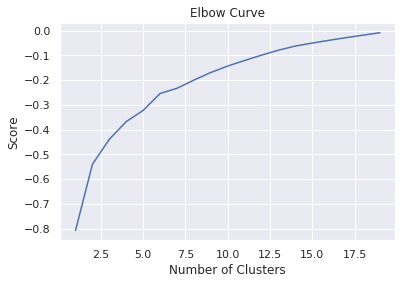

In [113]:
import matplotlib.pyplot as plt
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(paris_grouped_clustering).score(paris_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## K=7 is selected for kmeans clustering

In [114]:
# set number of clusters
kclusters = 7

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 5, 6, 3, 6, 4, 2, 4, 2], dtype=int32)

In [115]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,75001,Paris 1er Arrondissement,Paris 1er Arrondissement,12436,6.85,48.863512,2.338962,3,2.055,1.25,0.256875,3,Garden,Tea Room,Spa,Sculpture Garden,Salad Place
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31,48.865300,2.351360,5,3.155,8.75,2.760625,3,Spa,Pedestrian Plaza,Yoga Studio,Tea Room,Gym / Fitness Center
2,75003,Paris 3e Arrondissement,Paris 3e Arrondissement,12140,8.45,48.862666,2.360259,3,2.535,2.50,0.633750,5,Garden,Yoga Studio,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,Health Food Store
3,75004,Paris 4e Arrondissement,Paris 4e Arrondissement,12906,6.82,48.860845,2.352929,2,1.364,2.50,0.341000,5,Garden,Tea Room,Spa,Yoga Studio,Martial Arts Dojo
4,75005,Paris 5e Arrondissement,Paris 5e Arrondissement,11965,8.13,48.845812,2.348651,4,3.252,3.75,1.219500,2,Tea Room,Yoga Studio,Martial Arts Dojo,Garden,Gluten-free Restaurant


In [116]:
paris_merged.head()

,postCode,Borough,Neighborhood,avgHousePrice,croudRating,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,75001,Paris 1er Arrondissement,Paris 1er Arrondissement,12436,6.85,48.863512,2.338962,3,2.055,1.25,0.256875,3,Garden,Tea Room,Spa,Sculpture Garden,Salad Place
1,75002,Paris 2e Arrondissement,Paris 2e Arrondissement,11214,6.31,48.865300,2.351360,5,3.155,8.75,2.760625,3,Spa,Pedestrian Plaza,Yoga Studio,Tea Room,Gym / Fitness Center
2,75003,Paris 3e Arrondissement,Paris 3e Arrondissement,12140,8.45,48.862666,2.360259,3,2.535,2.50,0.633750,5,Garden,Yoga Studio,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,Health Food Store
3,75004,Paris 4e Arrondissement,Paris 4e Arrondissement,12906,6.82,48.860845,2.352929,2,1.364,2.50,0.341000,5,Garden,Tea Room,Spa,Yoga Studio,Martial Arts Dojo
4,75005,Paris 5e Arrondissement,Paris 5e Arrondissement,11965,8.13,48.845812,2.348651,4,3.252,3.75,1.219500,2,Tea Room,Yoga Studio,Martial Arts Dojo,Garden,Gluten-free Restaurant


In [117]:
## Building a bar chat for a better interpretation of the formed clusters

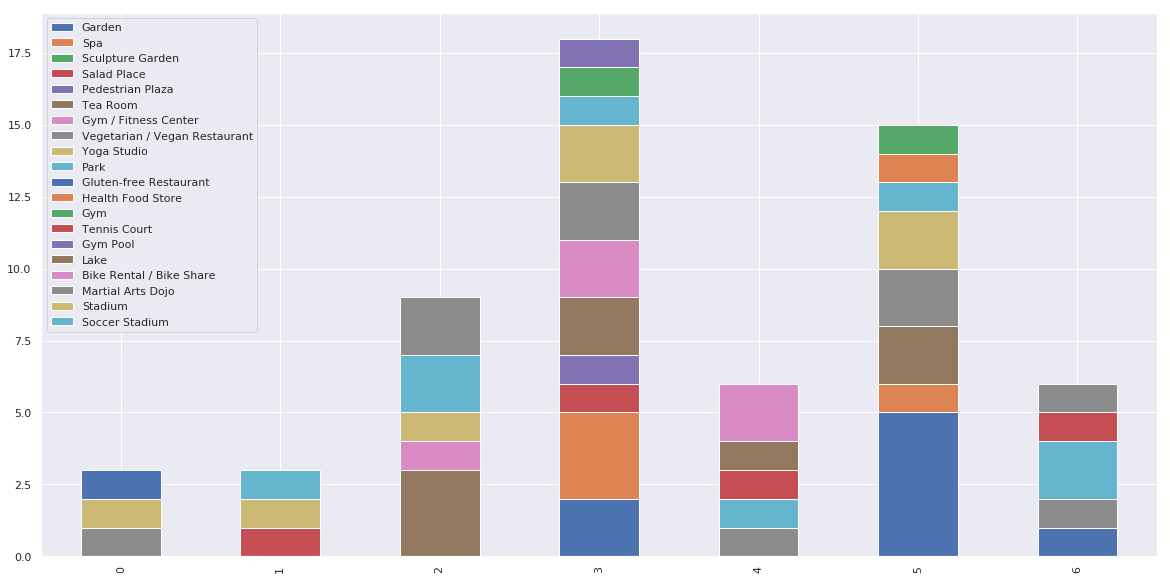

In [118]:
histPd = pd.DataFrame(columns=wellnessList)
for idx2 in range(7):
    y={}
    for idx1 in wellnessList:           
        curentCount = paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["1st Most Common Venue"] == idx1)].count()[0]+\
                        paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["2nd Most Common Venue"] == idx1)].count()[0]+\
                        paris_merged[(paris_merged["Cluster Labels"] == idx2) & (paris_merged["3rd Most Common Venue"] == idx1)].count()[0]
        y.update( {idx1 : curentCount} )
    histPd = histPd.append(y, ignore_index=True)
histPd.plot(kind='bar', 
             alpha=1, # 0-1, default value a= 0.5
             stacked=True,
             figsize=(20, 10),
            )

## Plot the obtained clusters in a Folium Map

In [132]:
# create map
map_clusters_wellness = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

paris_merged['wellnessScore'] = df['wellnessScore']
paris_merged['finalScore'] = df['finalScore']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, finalScore in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels'], df['finalScore']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ", Final Score=" + str(wellScore), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_wellness)
       
map_clusters_wellness

## Interpret the obtained clusters

In [120]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Paris 10e Arrondissement,48.879201,2.354391,7,3.367,3.75,1.262625,0,Gluten-free Restaurant,Yoga Studio,Vegetarian / Vegan Restaurant,Garden,Gym


In [121]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
19,Paris 20e Arrondissement,48.857126,2.409257,9,5.427,3.75,2.035125,1,Tennis Court,Stadium,Soccer Stadium,Yoga Studio,Lake


In [122]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Paris 5e Arrondissement,48.845812,2.348651,4,3.252,3.75,1.21950,2,Tea Room,Yoga Studio,Martial Arts Dojo,Garden,Gluten-free Restaurant
16,Paris 17e Arrondissement,48.878971,2.294156,6,4.284,3.75,1.60650,2,Tea Room,Park,Gym / Fitness Center,Martial Arts Dojo,Garden
18,Paris 19e Arrondissement,48.876829,2.394105,9,5.553,2.50,1.38825,2,Park,Martial Arts Dojo,Tea Room,Garden,Gluten-free Restaurant


In [123]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Paris 1er Arrondissement,48.863512,2.338962,3,2.055,1.25,0.256875,3,Garden,Tea Room,Spa,Sculpture Garden,Salad Place
1,Paris 2e Arrondissement,48.865300,2.351360,5,3.155,8.75,2.760625,3,Spa,Pedestrian Plaza,Yoga Studio,Tea Room,Gym / Fitness Center
7,Paris 8e Arrondissement,48.876048,2.315659,5,3.495,5.00,1.747500,3,Spa,Salad Place,Yoga Studio,Martial Arts Dojo,Garden
8,Paris 9e Arrondissement,48.880658,2.342372,6,4.662,5.00,2.331000,3,Vegetarian / Vegan Restaurant,Park,Garden,Gluten-free Restaurant,Gym
10,Paris 11e Arrondissement,48.855630,2.370806,7,4.641,7.50,3.480750,3,Vegetarian / Vegan Restaurant,Tea Room,Gym / Fitness Center,Pedestrian Plaza,Yoga Studio
13,Paris 14e Arrondissement,48.828590,2.307541,7,4.242,10.00,4.242000,3,Gym,Gym / Fitness Center,Gym Pool,Yoga Studio,Vegetarian / Vegan Restaurant


In [124]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Paris 16e Arrondissement,48.854928,2.255312,6,4.476,1.25,0.5595,4,Bike Rental / Bike Share,Lake,Vegetarian / Vegan Restaurant,Garden,Gluten-free Restaurant
17,Paris 18e Arrondissement,48.896511,2.334311,8,4.304,6.25,2.6900,4,Bike Rental / Bike Share,Park,Tennis Court,Tea Room,Garden


In [125]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Paris 3e Arrondissement,48.862666,2.360259,3,2.535,2.50,0.63375,5,Garden,Yoga Studio,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,Health Food Store
3,Paris 4e Arrondissement,48.860845,2.352929,2,1.364,2.50,0.34100,5,Garden,Tea Room,Spa,Yoga Studio,Martial Arts Dojo
5,Paris 6e Arrondissement,48.853537,2.343370,1,0.750,1.25,0.09375,5,Garden,Tea Room,Gym,Yoga Studio,Martial Arts Dojo
6,Paris 7e Arrondissement,48.855897,2.313699,1,0.713,2.50,0.17825,5,Park,Garden,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,Gym
11,Paris 12e Arrondissement,48.839734,2.380054,8,6.016,3.75,2.25600,5,Garden,Health Food Store,Yoga Studio,Vegetarian / Vegan Restaurant,Gluten-free Restaurant


In [126]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,avgHousePrice_binned,boroughCustomScore,wellnessScore,finalScore,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Paris 13e Arrondissement,48.829357,2.362456,8,5.216,10.0,5.216,6,Park,Tennis Court,Martial Arts Dojo,Garden,Gluten-free Restaurant
14,Paris 15e Arrondissement,48.842884,2.277391,7,5.012,5.0,2.506,6,Park,Vegetarian / Vegan Restaurant,Garden,Gluten-free Restaurant,Gym


## Plot the wellness score in a Choropleth Map

In [127]:
# create a plain paris map
paris_map_wellness = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
paris_map_wellness.choropleth(
    geo_data=paris_geo,
    data=df,
    columns=['Borough', 'wellnessScore'],
    key_on='feature.properties.l_ar',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Wellness Score'
)

# display map
paris_map_wellness

## Plot the Final score of the boroughs of Paris in a Choropleth Map

In [128]:
# create a plain paris map
paris_map_finalScore = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
paris_map_finalScore.choropleth(
    geo_data=paris_geo,
    data=df,
    columns=['Borough', 'finalScore'],
    key_on='feature.properties.l_ar',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Final Score'
)

# display map
paris_map_finalScore